In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [117]:
import Preprocessing.preprocessing as pp
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pylab
import math
import Preprocessing.image_processing as ip
import sklearn.metrics as metrics

Load in the data from a csv of pixel data, and a csv of labels

In [8]:
train_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/train_images.csv'
train_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/train_labels.csv'

X, Y = pp.load_XY(train_csv_x, train_csv_y)

Reshape the $Y$ vector (works better during the fitting)

In [57]:
Y = Y.reshape(-1)

Load the validation set

In [28]:
val_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/val_images.csv'
val_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/val_labels.csv'

X_val, Y_val = pp.load_XY(val_csv_x, val_csv_y)

### Train on 96x96 images

Fit a logistic regression to the data

In [19]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, Y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predict on the training data to calculate the accuracy (not the final evaluation metric for models)

In [25]:
y_pred_train = clf.predict(X)

In [89]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train-Y.T)))

Accuracy on train set:  0.9236666666666666


Predict on the validation data set

In [29]:
y_pred_val = clf.predict(X_val)

In [90]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val-Y_val.T)))

Accuracy on validation set:  0.5880000000000001


We can see that unregularized logistic regression performs poorly out of sample which is expected considering the input has $\approx 27,000$ features but we train it on $6,000$ examples which in turn creates problems of overfitting to the training data. Below we try different values of regularization and compare how that affects performance on both the training and the validation set.

In [97]:
reg = [np.exp(-i) for i in range(-10, 30, 2)]
reg = sorted(reg)

In [120]:
acc_train = []
acc_val = []
auc_train = []
auc_val = []
for i, c_i in enumerate(reg):
    print(i)
    # fit a logistic regression using regularization c_i
    clf = LogisticRegression(random_state=0, solver='lbfgs', C=c_i, multi_class='multinomial').fit(X, Y)
    # evaluate accuracy and AUROC score on the training set
    y_pred_train = clf.predict(X)
    proba_train = clf.predict_proba(X)[:,1]
    acc_train.append(1 - np.mean(np.abs(y_pred_train-Y.T)))
    auc_train.append(metrics.roc_auc_score(Y, proba_train))
    # evaluate accuracy on the validation set
    y_pred_val = clf.predict(X_val)
    proba_val = clf.predict_proba(X_val)[:,1]
    acc_val.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))
    auc_val.append(metrics.roc_auc_score(Y_val, proba_val))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


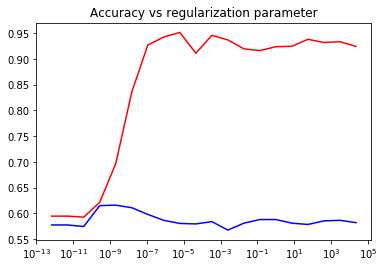

In [129]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train),'r')
plt.plot(np.array(reg), np.array(acc_val), 'b')
plt.xscale('log')
plt.show()

In [121]:
print("Highest accuracy: ", np.max(acc_val))
print("Highest AUROC: ", np.max(auc_val))
print("The optimal regularization value is: ", reg[np.argmax(auc_val)])

Highest accuracy:  0.616
Highest AUROC:  0.6677722277722278
The optimal regularization value is:  2.061153622438558e-09


In [122]:
clf = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val)], multi_class='multinomial').fit(X, Y)
probs = clf.predict_proba(X_val)[:,1]

fpr, tpr, threshold = metrics.roc_curve(Y_val, probs)
roc_auc = metrics.auc(fpr, tpr)

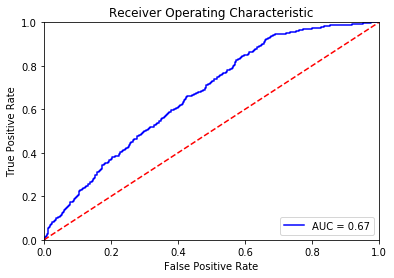

In [123]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Train on 32x32 images
Start by converting the $96\times96$ images to $32\times32$.

In [81]:
n = 32
X_32 = np.zeros((X.shape[0], n*n*3))
X_val_32 = np.zeros((X_val.shape[0], n*n*3))

In [85]:
for i in range(X.shape[0]):
    X_32[i] = ip.crop_center(X[i,:], (96,96,3), 32)

for j in range(X_val.shape[0]):
    X_val_32[j] = ip.crop_center(X_val[j,:], (96,96,3), 32)

Fit a logistic regression to the center $32\times32$ pixels.

In [77]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_32, Y)

In [79]:
y_pred_train_32 = clf_32.predict(X_32)

In [91]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train_32-Y.T)))

Accuracy on train set:  0.7391666666666667


Predict on the validation set.

In [87]:
y_pred_val_32 = clf_32.predict(X_val_32)

In [92]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val_32-Y_val.T)))

Accuracy on validation set:  0.5954999999999999


Train the model for multiple values of the regularization parameter.

In [124]:
acc_train_32 = []
acc_val_32 = []
auc_train_32 = []
auc_val_32 = []
for i, c_i in enumerate(reg):
    print(i)
    # fit a logistic regression using regularization c_i
    clf_32 = LogisticRegression(random_state=0, solver='lbfgs', C=c_i, multi_class='multinomial').fit(X_32, Y)
    # evaluate accuracy on the training set
    y_pred_train_32 = clf_32.predict(X_32)
    proba_train_32 = clf_32.predict_proba(X_32)[:,1]
    acc_train_32.append(1 - np.mean(np.abs(y_pred_train_32-Y.T)))
    auc_train_32.append(metrics.roc_auc_score(Y, proba_train_32))
    # evaluate accuracy on the validation set
    y_pred_val_32 = clf_32.predict(X_val_32)
    proba_val_32 = clf_32.predict_proba(X_val_32)[:,1]
    acc_val_32.append(1 - np.mean(np.abs(y_pred_val_32-Y_val.T)))
    auc_val_32.append(metrics.roc_auc_score(Y_val, proba_val_32))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


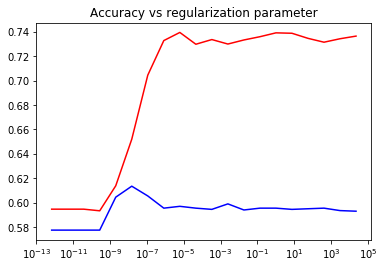

In [128]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_32),'r')
plt.plot(np.array(reg), np.array(acc_val_32), 'b')
plt.xscale('log')
plt.show()

In [125]:
print("Highest accuracy: ", np.max(acc_val_32))
print("Highest AUROC: ", np.max(auc_val_32))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_32)])

Highest accuracy:  0.6134999999999999
Highest AUROC:  0.6608243039012269
The optimal regularization value is:  1.522997974471263e-08


In [126]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val_32)], multi_class='multinomial').fit(X_32, Y)
probs_32 = clf_32.predict_proba(X_val_32)[:,1]

fpr_32, tpr_32, threshold_32 = metrics.roc_curve(Y_val, probs_32)
roc_auc_32 = metrics.auc(fpr_32, tpr_32)

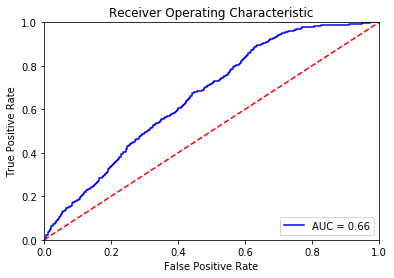

In [127]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_32, tpr_32, 'b', label = 'AUC = %0.2f' % roc_auc_32)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Results
A logistic regression model using the full scale images performs better out-of-sample than a model using only the center of the image. However, neither model is close to the leaderboard scores on Kaggle (around 0.95 compared to 0.66-0.67 for our models). Below we perform some error analysis in order to get a better understanding of how we can potentially improve the performance.

First we look at how the performance of the model behaves when we increase the size of the training data:

In [138]:
acc_train_32_ea = []
acc_val_32_ea = []
auc_train_32_ea = []
auc_val_32_ea = []
c = reg[np.argmax(auc_val_32)]
for i in range(10,X.shape[0]+11, 100):
    # fit a logistic regression using regularization c
    clf = LogisticRegression(random_state=0, solver='lbfgs', C=c, multi_class='multinomial').fit(X_32[:i], Y[:i])
    # evaluate accuracy and AUROC score on the training set
    y_pred_train = clf.predict(X_32[:i])
    proba_train = clf.predict_proba(X_32[:i])[:,1]
    acc_train_32_ea.append(1 - np.mean(np.abs(y_pred_train-Y[:i].T)))
    auc_train_32_ea.append(metrics.roc_auc_score(Y[:i], proba_train))
    # evaluate accuracy on the validation set
    y_pred_val = clf.predict(X_val_32)
    proba_val = clf.predict_proba(X_val_32)[:,1]
    acc_val_32_ea.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))
    auc_val_32_ea.append(metrics.roc_auc_score(Y_val, proba_val))

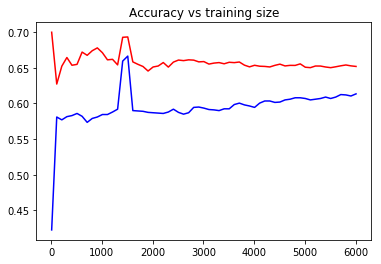

In [139]:
plt.title('Accuracy vs training size')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(acc_train_32_ea),'r')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(acc_val_32_ea), 'b')
plt.show()

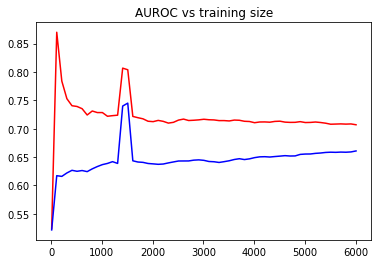

In [140]:
plt.title('AUROC vs training size')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(auc_train_32_ea),'r')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(auc_val_32_ea), 'b')
plt.show()